## Part 1.2 Exploratory Data Analysis

#### Importing Libraries

In [101]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('ggplot')
%matplotlib inline

import logging
logging.getLogger('matplotlib.category').setLevel(logging.ERROR)

from scipy.stats import chi2_contingency, spearmanr, pearsonr
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.feature_selection import mutual_info_classif

#### Dataset Preprocessing for Visualizations

In [83]:
kidney_data = pd.read_csv('../Dataset/ckd-dataset-v2.csv')
kidney_data = kidney_data.loc[2:, :]
kidney_data = kidney_data.drop(columns=['affected'])

binary_vars = ['bp (Diastolic)', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
ordinal_vars = [col for col in kidney_data.columns if col not in binary_vars]

In [84]:
import re

def get_sorted_range_values(df, column_name):
    def get_sort_key(val):
        val = val.strip()
        if re.match(r'^<\s*\d+', val):
            return float(val.replace('<', '').strip()) - 1e-5
        elif re.match(r'^≥\s*\d+', val):
            return float(val.replace('≥', '').strip()) + 1e-5
        elif re.match(r'^\d+', val):
            parts = re.findall(r'\d+(?:\.\d+)?', val)
            if len(parts) == 2:
                return (float(parts[0]) + float(parts[1])) / 2
            elif len(parts) == 1:
                return float(parts[0])
        return float('inf')

    unique_values = df[column_name].dropna().unique()
    sorted_values = sorted(unique_values, key=get_sort_key)
    return sorted_values


#### Ordinal variables histogram plots

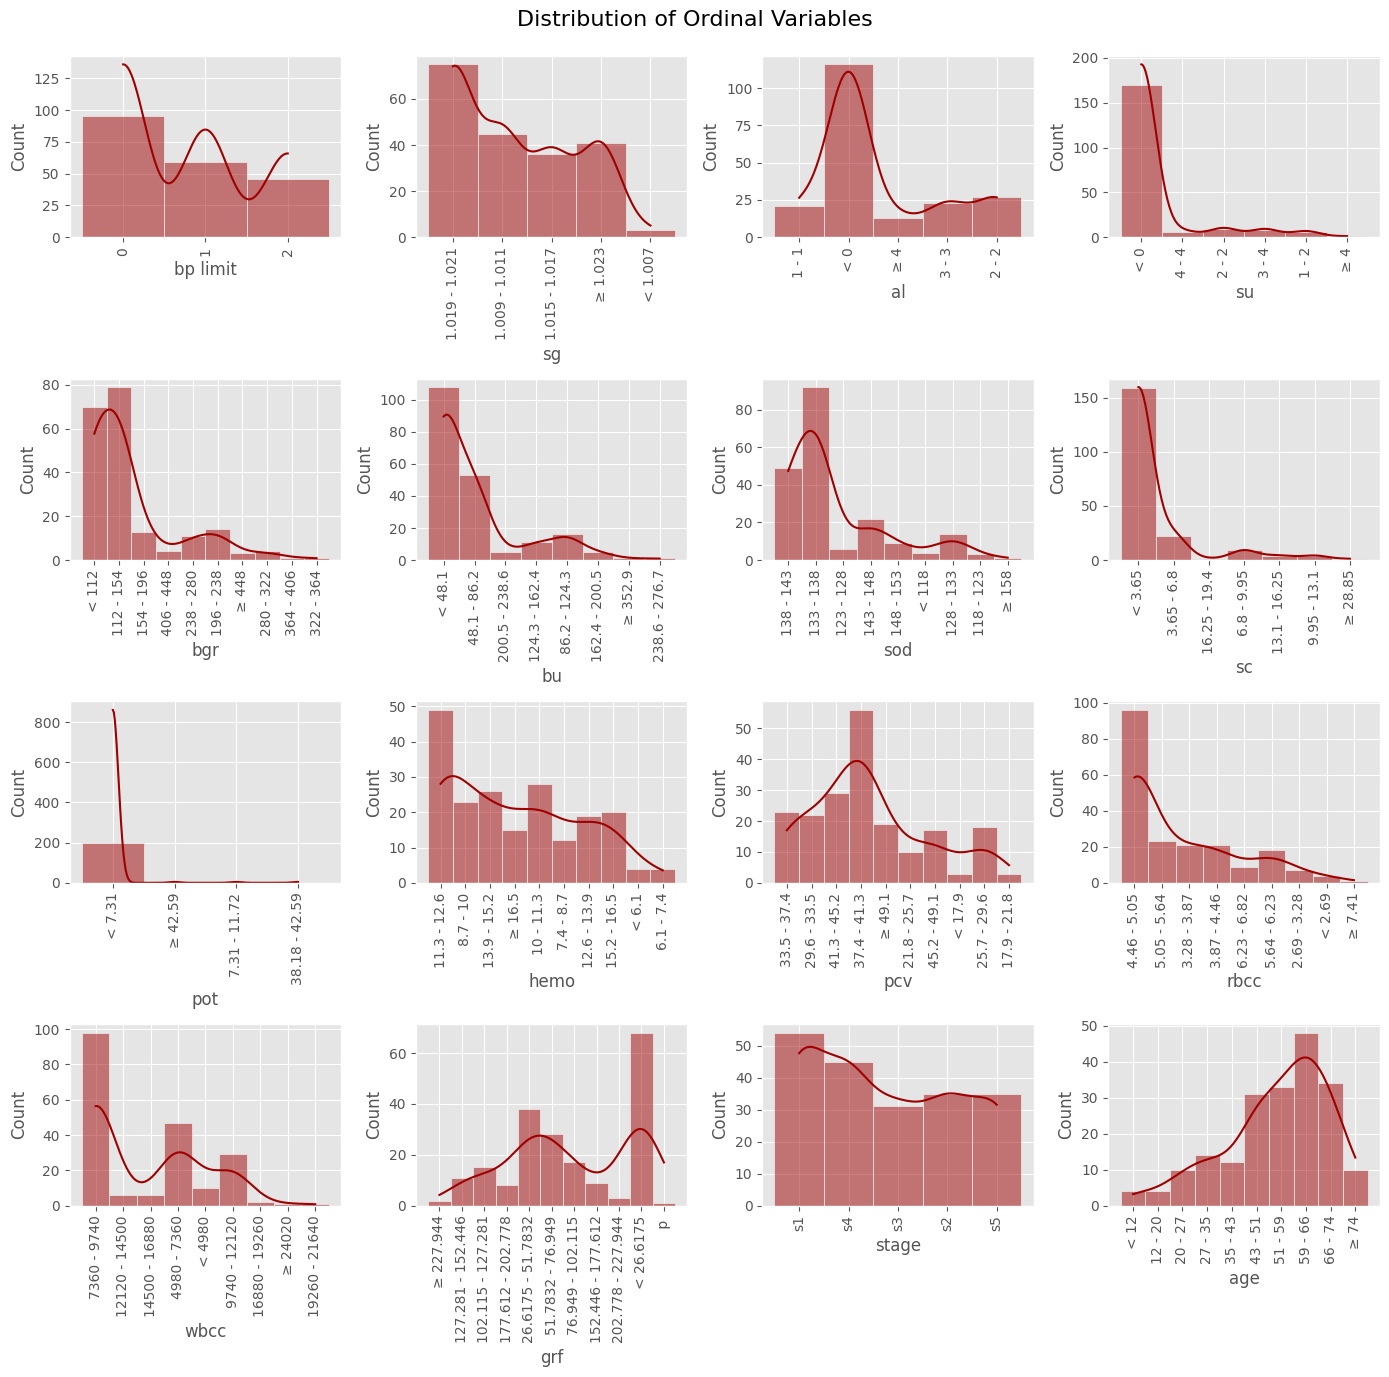

In [85]:
plt.figure(figsize=(14, 14))
plotnumber = 1

for column in ordinal_vars:
    ax = plt.subplot(4, 4, plotnumber)
    plt.xlabel(column)
    sorted_order = get_sorted_range_values(kidney_data, column)
    sns.histplot(kidney_data, x=column, discrete=True, kde=True, color='#9f0000', alpha=0.5)
    plt.xticks(rotation=90)
    plotnumber += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Distribution of Ordinal Variables', fontsize=16)
plt.show()


- The variable 'grf' contains an unknown value 'p'. In the encoded dataset, it is replaced by the mode value of the series, i.e. the interval category '<26.6175'.
- Variables like al, su, bgr, sc, and pot are more likely to be skewed toward one dominant category during inference.

#### Binary variables bar plots

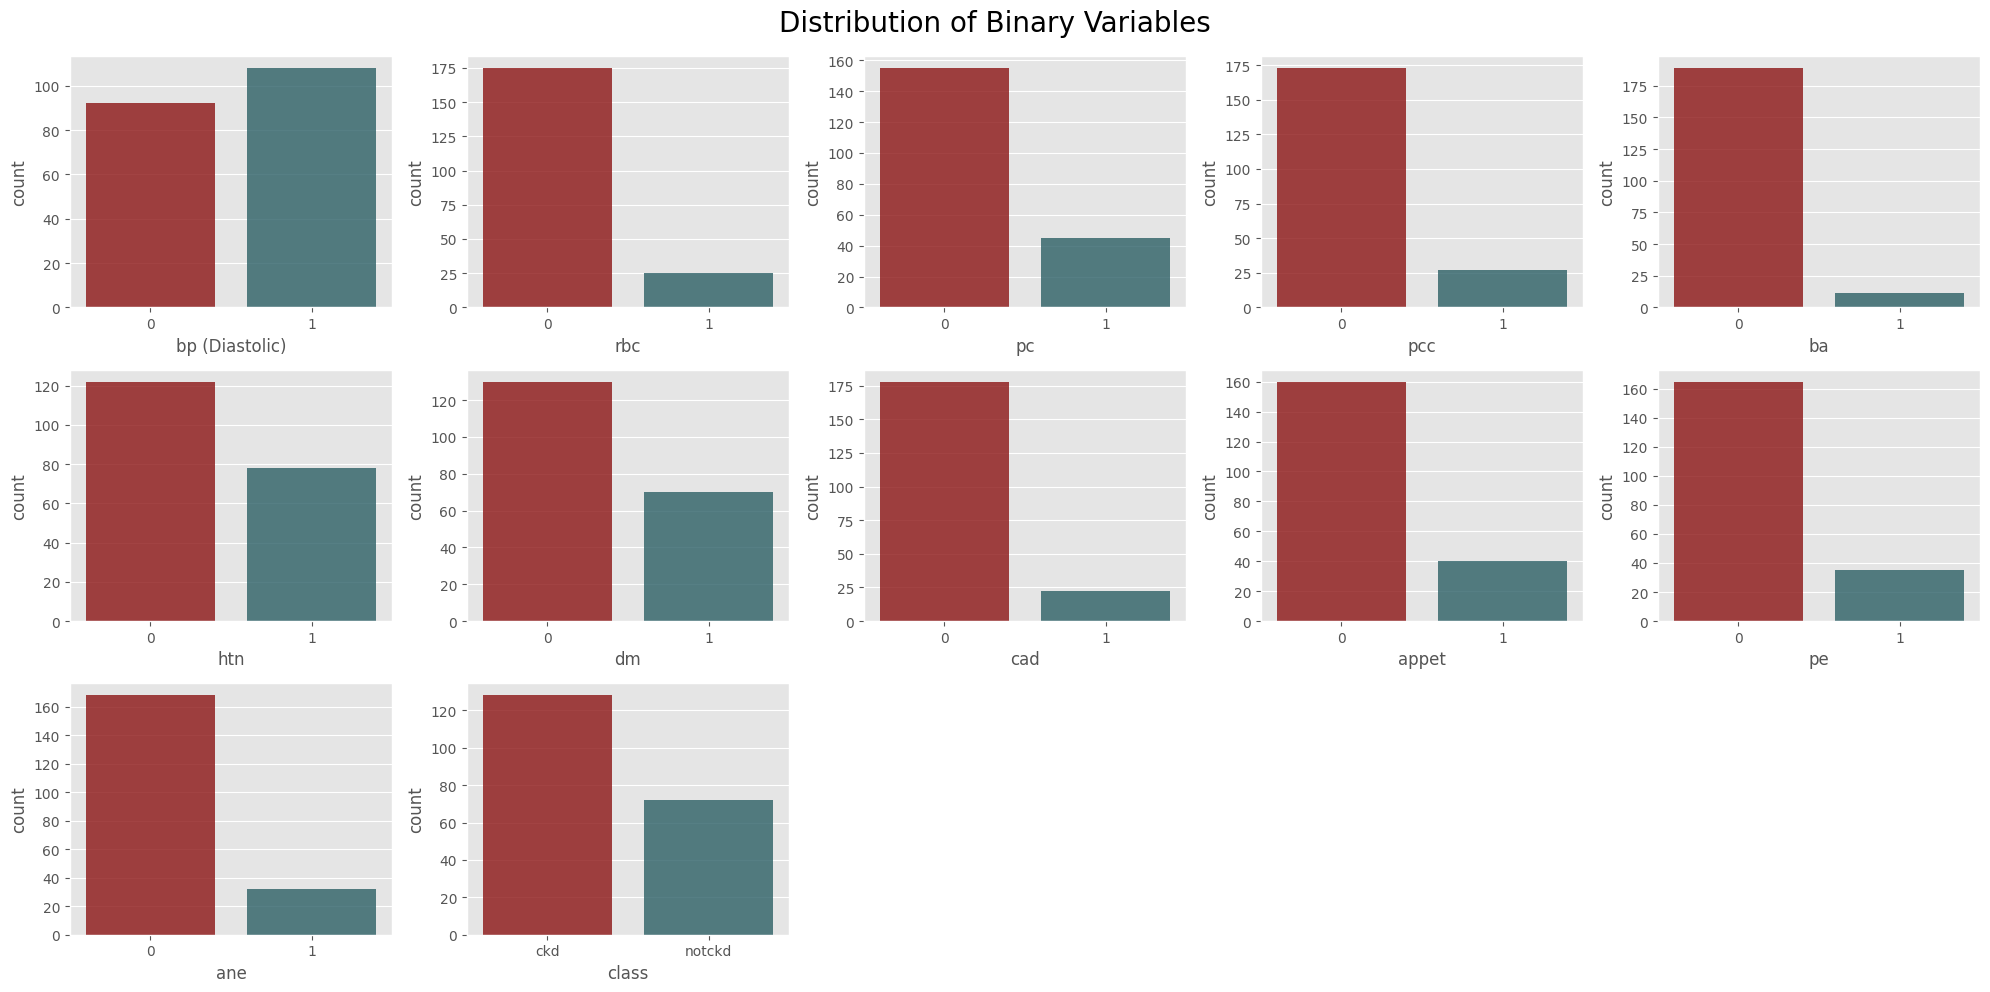

In [86]:
plt.figure(figsize=(20, 16))
plotnumber = 1

for column in binary_vars:
    ax = plt.subplot(5, 5, plotnumber)
    plt.xlabel(column)
    sorted_order = get_sorted_range_values(kidney_data, column)
    sns.countplot(x=column, data=kidney_data, order=sorted_order, hue=column, palette=['#9f0000', '#22666F'], alpha=0.8)
    plotnumber += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Distribution of Binary Variables', fontsize=20)
plt.show()


Variables like rbc, pcc, ba, cad, appet, pe and ane are more likely to be influenced by the dominant 0 category during inference.

#### Class Imbalance

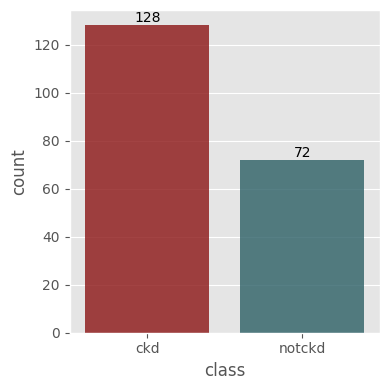

In [87]:
plt.figure(figsize=(4, 4))

plt.xlabel('class')
class_bp = sns.countplot(x=kidney_data['class'], data=kidney_data, hue=kidney_data['class'], palette=['#9f0000', '#22666F'], alpha=0.8)
for container in class_bp.containers:
    class_bp.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()


In [88]:
print(f"The dataset contains {kidney_data['class'].value_counts().iloc[0]} samples of ckd class and {kidney_data['class'].value_counts().iloc[1]} samples of notckd class.")

The dataset contains 128 samples of ckd class and 72 samples of notckd class.


The above bar chart depicts class imbalance in the dataset due to the presence of more records corresponding to the 'ckd' class as compared to the 'notckd' class. This moderate imbalance will be more dominant in individual client data partitions of the original data while working in the federated setting and will require necessary techniques to be handled. 

#### Correlation Analysis

**Null Hypothesis**: No association between risk factor and the target class.

We reject the null hypothsis if p-value < 0.05.

In [89]:
# Encoded data to support correlation analysis
kidney_data = pd.read_csv('../Dataset/cleaned_kidney_data.csv')

In [118]:
results = []

for column in kidney_data.columns:
    contingency_table = pd.crosstab(kidney_data['class'], kidney_data[column])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Variable': column,
        'Chi-square Statistic': chi2,
        'P-value': round(p, 6)
    })

chi2_results_df = pd.DataFrame(results)

chi2_results_df = chi2_results_df.sort_values(by='Chi-square Statistic', ascending=False).reset_index(drop=True)[1:]

chi2_results_df

,Variable,Chi-square Statistic,P-value
1,hemo,147.339481,0.000000
2,pcv,134.048938,0.000000
3,stage,117.403825,0.000000
4,grf,116.625215,0.000000
5,rbcc,105.716526,0.000000
6,sg,96.403568,0.000000
7,al,81.465517,0.000000
8,htn,69.387559,0.000000
9,sod,67.372777,0.000000
10,dm,58.196925,0.000000


In [ ]:
# Filtering significant variables based on p-value
significant_vars = chi2_results_df[chi2_results_df['P-value'] < 0.05]['Variable'].tolist()
print(f"We reject the null hypothesis for the variables - {significant_vars}")

Significant variables based on Chi-square test: ['hemo', 'pcv', 'stage', 'grf', 'rbcc', 'sg', 'al', 'htn', 'sod', 'dm', 'bu', 'bgr', 'bp_limit', 'pc', 'age', 'sc', 'appet', 'pe', 'su', 'ane', 'wbcc', 'pcc', 'rbc', 'cad', 'ba']


Risk factors including hemo, pcv, stage, grf, rbcc and sg with high chi-square statistic show strong evidence of association to the class variable. 

We use **Spearman correlation (ρ)** to compute ordinal-ordinal and ordinal-binary relationship strength and **Pearson correlation (φ)** to compute binary-binary relationship strength.

In [ ]:
binary_vars = ['bp_diastolic', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
ordinal_vars = [col for col in kidney_data.columns if col not in binary_vars]
all_vars = binary_vars + ordinal_vars

# Initialize empty matrix
corr_matrix = pd.DataFrame(index=all_vars, columns=all_vars)

for var1 in all_vars:
    for var2 in all_vars:
        if var1 == var2:
            corr = 1.0
        elif (var1 in binary_vars) and (var2 in binary_vars):
            corr, _ = pearsonr(kidney_data[var1], kidney_data[var2])
        else:
            corr, _ = spearmanr(kidney_data[var1], kidney_data[var2])

        corr_matrix.loc[var1, var2] = corr


corr_matrix = corr_matrix.astype(float)

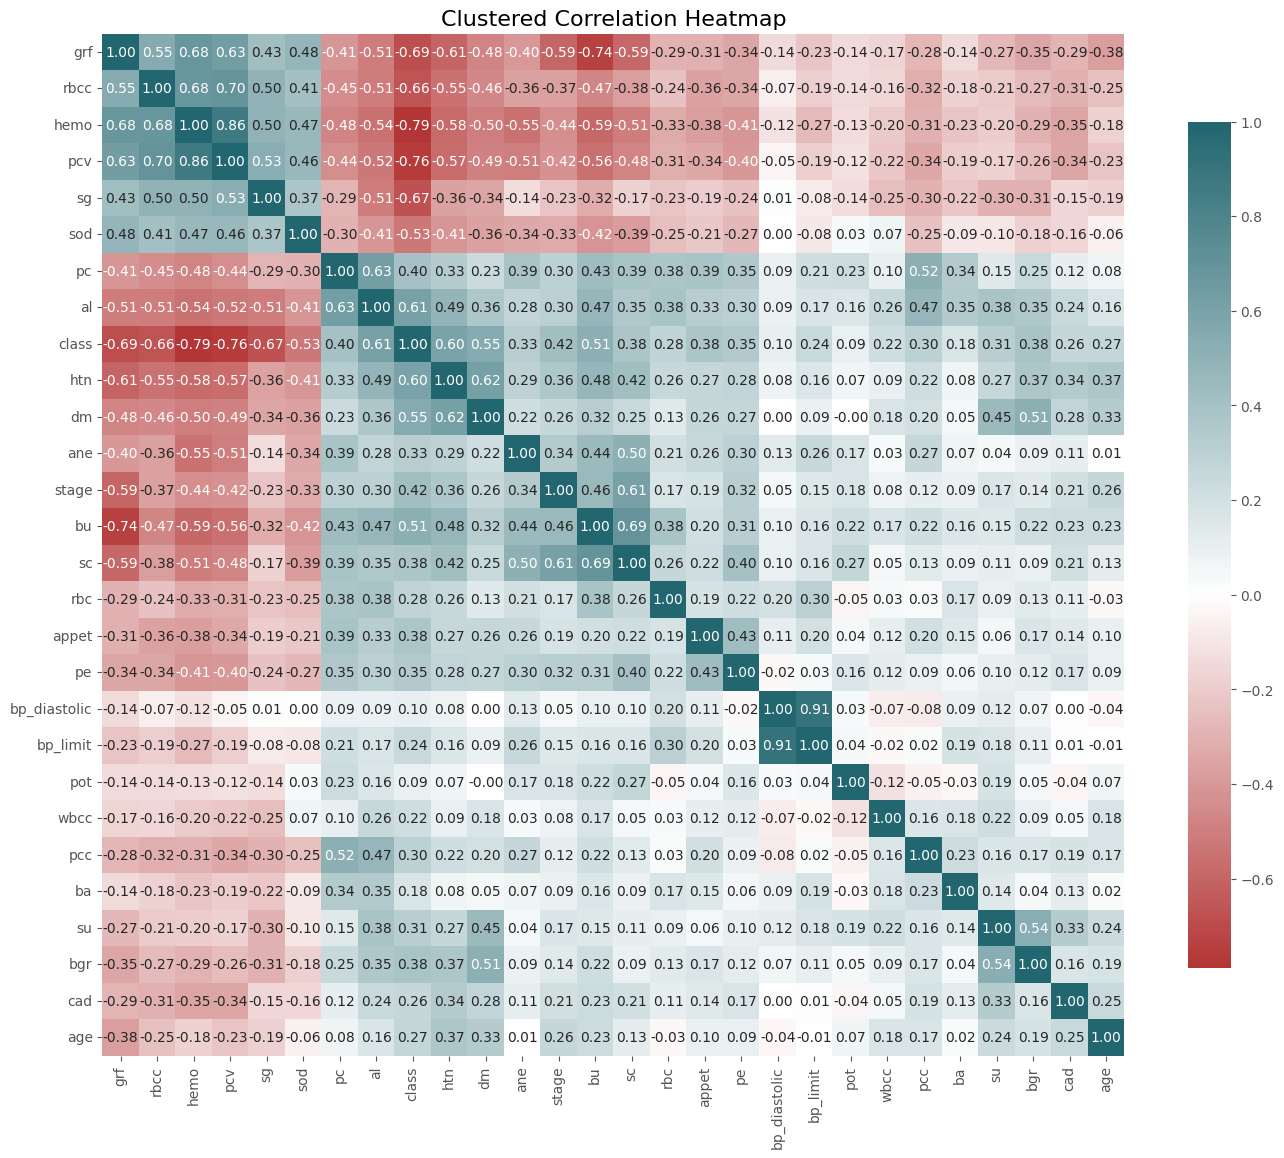

In [108]:
# Hierarchical clustering in Correlation Matrix
linkage_rows = linkage(corr_matrix, method='ward')
linkage_cols = linkage(corr_matrix.T, method='ward')

row_order = leaves_list(linkage_rows)
col_order = leaves_list(linkage_cols)

corr_reordered = corr_matrix.iloc[row_order, col_order]

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging', 
    ['#9f0000', 'white', '#22666F']  
)

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_reordered,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Clustered Correlation Heatmap", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Clustering highlights the strongly associated risk factors, which in the next figure share similar correlation patterns with the class variable. For e.g. sg, hemo, sod, pcv, rbcc and grf are clustered together and are negatively correlated with the class variable.

#### Visualizing correlation coefficients

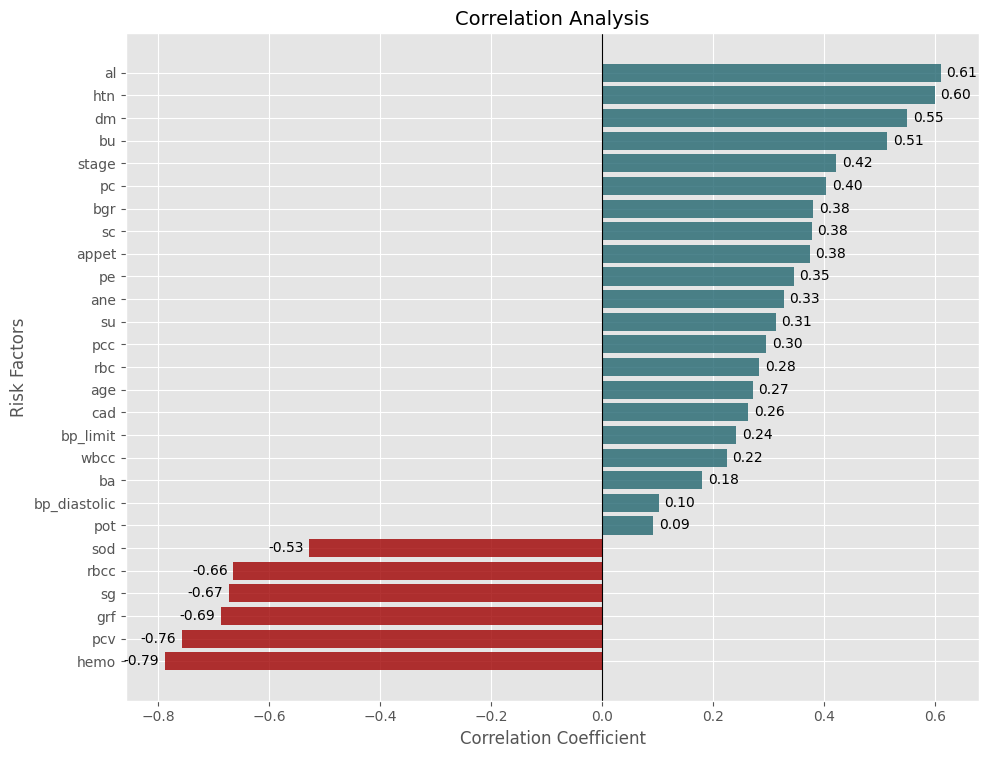

In [ ]:
corr_series = corr_reordered['class']
corr_df = pd.DataFrame(corr_series).drop(index='class') 
corr_df = corr_df.rename(columns={'class': 'Correlation'})
corr_df = corr_df.sort_values(by='Correlation', ascending=True)

corr_df['Color'] = corr_df['Correlation'].apply(lambda x: '#9f0000' if x < 0 else '#22666F')

plt.figure(figsize=(10, 8))
bars = plt.barh(corr_df.index, corr_df['Correlation'], color=corr_df['Color'], alpha=0.8)

for bar in bars:
    plt.text(
        bar.get_width() + 0.01 * (-1 if bar.get_width() < 0 else 1),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va='center',
        ha='left' if bar.get_width() > 0 else 'right',
        color='black'
    )

plt.title("Correlation Analysis", fontsize=14)
plt.axvline(0, color='black', linewidth=0.8)  
plt.xlabel("Correlation Coefficient")
plt.ylabel("Risk Factors")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Mutual Information Analysis

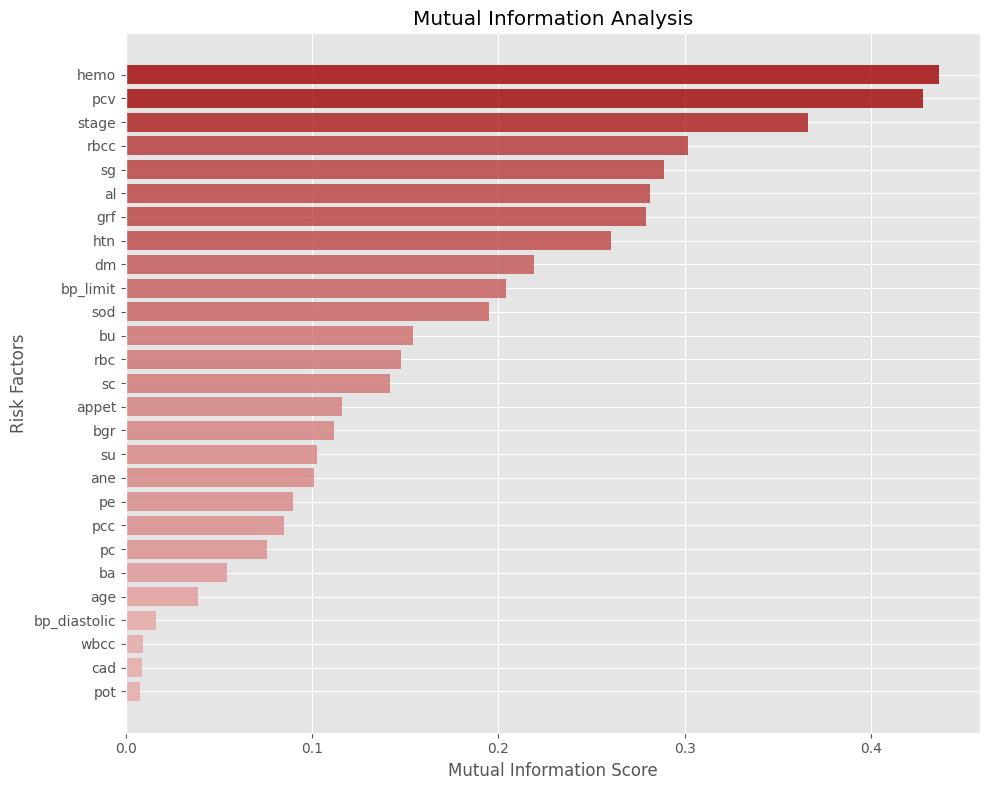

In [113]:
X = kidney_data.drop(columns=['class'])
y = kidney_data['class']

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information Score': mi_scores
}).sort_values(by='Mutual Information Score', ascending=True)

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_red', 
    ['#e5a7a5', '#9f0000']  
)

from matplotlib.colors import LinearSegmentedColormap, Normalize

norm = Normalize(vmin=mi_df['Mutual Information Score'].min(), vmax=mi_df['Mutual Information Score'].max())
colors = custom_cmap(norm(mi_df['Mutual Information Score']))

plt.figure(figsize=(10, 8))
plt.barh(mi_df['Feature'], mi_df['Mutual Information Score'], color=colors, alpha=0.8)
plt.xlabel('Mutual Information Score')
plt.ylabel('Risk Factors')
plt.title('Mutual Information Analysis')
plt.tight_layout()
plt.show()


The mutual information scores further supports the strength of association between variables such as **hemo, pcv, rbcc, sgm al, grf, htn, dm** and the target class variable. 